In [2]:
""" Batch generate meteor simulations using an ablation model and random physical parameters, and store the 
simulations to disk. """


from __future__ import print_function, division, absolute_import, unicode_literals

import os
import json
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import pickle
import pandas as pd

from wmpl.MetSim.GUI import SimulationResults
from wmpl.MetSim.MetSimErosion import Constants
from wmpl.MetSim.MetSimErosion import runSimulation as runSimulationErosion
from wmpl.MetSim.ML.GenerateSimulations import generateErosionSim,saveProcessedList,MetParam, extractSimData
from wmpl.Utils.AtmosphereDensity import fitAtmPoly
from wmpl.Utils.Math import padOrTruncate
from wmpl.Utils.OSTools import mkdirP
from wmpl.Utils.TrajConversions import J2000_JD, date2JD
from wmpl.Utils.Pickling import savePickle, loadPickle
from wmpl.Utils.PyDomainParallelizer import domainParallelizer



### CONSTANTS ###

# Length of data that will be used as an input during training
DATA_LENGTH = 256

# Default number of minimum frames for simulation
MIN_FRAMES_VISIBLE = 4

### ###


##############################################################################################################
### SIMULATION PARAMETER CLASSES ###
### MAKE SURE TO ADD ANY NEW CLASSES TO THE "SIM_CLASSES" VARIABLE!


class ErosionSimParametersEMCCD(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +9.0
        self.lim_mag_brightest = +0.0

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 1210

        # System FPS
        self.fps = 30

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(5e-7, 1e-3)
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        self.v_init = MetParam(11000, 72000)
        self.param_list.append("v_init")

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(0.0), np.radians(80.0))
        self.param_list.append("zenith_angle")

        # Density range (kg/m^3)
        self.rho = MetParam(100, 6000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.005/1e6, 0.5/1e6)
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(70000, 130000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 3.0)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 5e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # 0.155

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


class ErosionSimParametersEMCCD_PER(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        self.lim_mag_faintest = +6    # change the startng height
        self.lim_mag_brightest = +4   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(1e-7, 1e-4)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        self.v_init = MetParam(57500, 65000)
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(15.0), np.radians(73.0))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.005/1e6, 0.05/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(100000, 120000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v57_slow(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        self.lim_mag_faintest = +5.30 # change the startng height
        self.lim_mag_brightest = +5.20   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        # self.lim_mag_len_end_faintest = self.lim_mag_faintest
        # self.lim_mag_len_end_brightest = self.lim_mag_brightest
        self.lim_mag_len_end_faintest = +5.55
        self.lim_mag_len_end_brightest = +5.45


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(5e-7, 7e-7)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        self.v_init = MetParam(57400, 57600) # 57500.18
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(45.4), np.radians(45.6))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(114000, 119000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v59_heavy(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        self.lim_mag_faintest = +4.20 # change the startng height
        self.lim_mag_brightest = +4.10   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        # self.lim_mag_len_end_faintest = self.lim_mag_faintest
        # self.lim_mag_len_end_brightest = self.lim_mag_brightest
        self.lim_mag_len_end_faintest = +2.95
        self.lim_mag_len_end_brightest = +2.85


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(1e-5, 2e-5)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        self.v_init = MetParam(59740, 59940) # 59836.84
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(39.7), np.radians(39.9))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(115000, 119000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v60_light(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        # self.lim_mag_faintest = +5.70 # change the startng height
        # self.lim_mag_brightest = +5.60   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        # self.lim_mag_len_end_faintest = self.lim_mag_faintest
        # self.lim_mag_len_end_brightest = self.lim_mag_brightest
        # self.lim_mag_len_end_faintest = +5.75
        # self.lim_mag_len_end_brightest = +5.65

        self.lim_mag_faintest = +6    # change the startng height
        self.lim_mag_brightest = +5.5   # change the startng height
        # self.lim_mag_faintest = +5    # change the startng height
        # self.lim_mag_brightest = +4.5   # change the startng height
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(1.0e-7, 1.1e-7)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        # self.v_init = MetParam(59700, 59900) # 60051.34
        # self.v_init = MetParam(59950, 60150) # 60051.34
        self.v_init = MetParam(60000, 60150) # 60051.34
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(39.2), np.radians(39.4))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(105000, 109000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v61_shallow(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        self.lim_mag_faintest = +6    # change the startng height
        self.lim_mag_brightest = +4   # change the startng height
        # self.lim_mag_faintest = +5.50 # change the startng height
        # self.lim_mag_brightest = +4.95   # change the startng height
        # self.lim_mag_faintest = +6 # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest
        # self.lim_mag_len_end_faintest = +6
        # self.lim_mag_len_end_brightest = +5
        # self.lim_mag_len_end_faintest = +5.5
        # self.lim_mag_len_end_brightest = +4.95


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(6.5e-7, 7.5e-7)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        # self.v_init = MetParam(61100, 61300) # 61460.80
        self.v_init = MetParam(61350, 61480) # 61460.80
        # self.v_init = MetParam(61350, 61550) # 61460.80
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(63.17), np.radians(63.27))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(113000, 117000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v62_steep(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        self.lim_mag_faintest = +5.40 # change the startng height
        self.lim_mag_brightest = +5.30   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        # self.lim_mag_len_end_faintest = self.lim_mag_faintest
        # self.lim_mag_len_end_brightest = self.lim_mag_brightest
        self.lim_mag_len_end_faintest = +4.75
        self.lim_mag_len_end_brightest = +4.65


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(5e-7, 7e-7)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        self.v_init = MetParam(62500, 62700) #62579.06
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(24.35), np.radians(24.45))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(112000, 119000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###

class ErosionSimParametersEMCCD_PER_v65_fast(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Perseids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = date2JD(2020, 8, 10, 10, 0, 0)


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        # self.lim_mag_faintest = +7.2    # change
        # self.lim_mag_brightest = +5.2   # change
        # self.lim_mag_faintest = +8    # change the startng height
        # self.lim_mag_brightest = +5   # change the startng height
        self.lim_mag_faintest = +4.55 # change the startng height
        self.lim_mag_brightest = +4.45   # change the startng height

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        # self.lim_mag_len_end_faintest = self.lim_mag_faintest
        # self.lim_mag_len_end_brightest = self.lim_mag_brightest
        self.lim_mag_len_end_faintest = +6.10
        self.lim_mag_len_end_brightest = +5.90


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 32

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(6e-7, 8e-7)
        self.param_list.append("m_init") # change

        # Initial velocity range (m/s)
        self.v_init = MetParam(64900, 65100) #64997.01929105718
        self.param_list.append("v_init") # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(51.6), np.radians(51.8))
        self.param_list.append("zenith_angle") # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 1000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.008/1e6, 0.03/1e6) 
        self.param_list.append("sigma")
        # self.sigma = MetParam(0.005/1e6, 0.5/1e6)


        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(111000, 116000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 2.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-10)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-10, 5e-8)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length! 
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # THIS IS A USELLES VARIABLE

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = +9
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###



class ErosionSimParametersEMCCD_GEM(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Geminids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +8.0    # change
        self.lim_mag_brightest = +5.5   # change

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 30

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(2e-7, 2.7e-6)   # change
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        self.v_init = MetParam(34000, 37000)
        self.param_list.append("v_init")    # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(11.0), np.radians(42.5))
        self.param_list.append("zenith_angle")  # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 2000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.01/1e6, 0.1/1e6) 
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(96000, 110000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 3.0)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 5e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # 0.13 self.visibility_time_min = 

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


class ErosionSimParametersEMCCD_ORI(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Geminids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +6.2    # change
        self.lim_mag_brightest = +4.7   # change

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 30

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(9e-8, 1e-6)   # change
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        self.v_init = MetParam(63800, 68700)
        self.param_list.append("v_init")    # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(27.9), np.radians(53.5))
        self.param_list.append("zenith_angle")  # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 2000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.01/1e6, 0.1/1e6) 
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(105000, 120000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 3.0)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 5e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # 0.13 self.visibility_time_min = 4/30

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


class ErosionSimParametersEMCCD_ETA(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Geminids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +5.8    # change
        self.lim_mag_brightest = +3.7   # change

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 30

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(9e-8, 1e-6)   # change
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        self.v_init = MetParam(65000, 68400)
        self.param_list.append("v_init")    # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(64.8), np.radians(80.2))
        self.param_list.append("zenith_angle")  # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 2000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.01/1e6, 0.1/1e6) 
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(105000, 120000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 3.0)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 1e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # 0.13 self.visibility_time_min = 

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


class ErosionSimParametersEMCCD_SDA(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Geminids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +6.9    # change
        self.lim_mag_brightest = +4.8   # change

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 30

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        self.m_init = MetParam(2.2e-7, 2.5e-6)   # change
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        self.v_init = MetParam(37000, 43000)
        self.param_list.append("v_init")    # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(58.3), np.radians(72.1))
        self.param_list.append("zenith_angle")  # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 2000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.01/1e6, 0.1/1e6) 
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(96000, 110000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e6)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1.5, 3.0)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 5e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 4/self.fps # DUMMY VARIABLE # 0.13 self.visibility_time_min = 

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


class ErosionSimParametersEMCCD_CAP(object):
    def __init__(self):
        """ Range of physical parameters for the erosion model, EMCCD system for Geminids. """


        # Define the reference time for the atmosphere density model as J2000
        self.jdt_ref = J2000_JD.days


        ## Atmosphere density ##
        #   Use the atmosphere density for the time at J2000 and coordinates of Elginfield
        self.dens_co = fitAtmPoly(np.radians(43.19301), np.radians(-81.315555), 60000, 180000, self.jdt_ref)

        ##


        # List of simulation parameters
        self.param_list = []



        ## System parameters ##

        # System limiting magnitude (given as a range)
        self.lim_mag_faintest = +7.6    # change
        self.lim_mag_brightest = +5.7   # change

        # Limiting magnitude for length measurements end (given by a range)
        #   This should be the same as the two value above for all other systems except for CAMO
        self.lim_mag_len_end_faintest = self.lim_mag_faintest
        self.lim_mag_len_end_brightest = self.lim_mag_brightest


        # Power of a zero-magnitude meteor (Watts)
        self.P_0M = 935

        # System FPS
        self.fps = 80

        # Time lag of length measurements (range in seconds) - accomodate CAMO tracking delay of 8 frames
        #   This should be 0 for all other systems except for the CAMO mirror tracking system
        self.len_delay_min = 0
        self.len_delay_max = 0

        # Simulation height range (m) that will be used to map the output to a grid
        self.sim_height = MetParam(70000, 130000)


        ##


        ## Physical parameters

        # Mass range (kg)
        # self.m_init = MetParam(3.8e-7, 5.3e-6)   # change
        self.m_init = MetParam(1e-8, 1e-6)   # change
        self.param_list.append("m_init")

        # Initial velocity range (m/s)
        # self.v_init = MetParam(22000, 27000)
        self.v_init = MetParam(20000, 30000)
        self.param_list.append("v_init")    # change

        # Zenith angle range
        self.zenith_angle = MetParam(np.radians(48), np.radians(65))
        self.param_list.append("zenith_angle")  # change

        # Density range (kg/m^3)
        self.rho = MetParam(100, 2000)
        self.param_list.append("rho")

        # Intrinsic ablation coeff range (s^2/m^2)
        self.sigma = MetParam(0.01/1e6, 0.1/1e6) 
        self.param_list.append("sigma")

        ##


        ## Erosion parameters ##
        ## Assumes no change in erosion once it starts!

        # Erosion height range
        self.erosion_height_start = MetParam(90000, 110000)
        self.param_list.append("erosion_height_start")

        # Erosion coefficient (s^2/m^2)
        self.erosion_coeff = MetParam(0.0, 1.0/1e4)
        self.param_list.append("erosion_coeff")

        # Mass index
        self.erosion_mass_index = MetParam(1, 3.5)
        self.param_list.append("erosion_mass_index")

        # Minimum mass for erosion
        self.erosion_mass_min = MetParam(5e-12, 1e-8)
        self.param_list.append("erosion_mass_min")

        # Maximum mass for erosion
        self.erosion_mass_max = MetParam(1e-11, 5e-7)
        self.param_list.append("erosion_mass_max")

        ## 


        ### Simulation quality checks ###

        # Minimum time above the limiting magnitude (10 frames)
        #   This is a minimum for both magnitude and length!
        # self.visibility_time_min = 10/self.fps # 0.13 self.visibility_time_min = 

        ### ###


        ### Added noise ###

        # Standard deviation of the magnitude Gaussian noise
        self.mag_noise = 0.1

        # SD of noise in length (m)
        self.len_noise = 20.0

        ### ###


        ### Fit parameters ###

        # Length of input data arrays that will be given to the neural network
        self.data_length = DATA_LENGTH

        ### ###


        ### Output normalization range ###

        # Height range (m)
        self.ht_min = 70000
        self.ht_max = 130000

        # Magnitude range
        self.mag_faintest = self.lim_mag_faintest
        self.mag_brightest = -2


        # Compute length range
        self.len_min = 0
        self.len_max = self.v_init.max*self.data_length/self.fps


        ### ###


# List of classed that can be used for data generation and postprocessing
SIM_CLASSES = [ErosionSimParametersEMCCD, 
               ErosionSimParametersEMCCD_PER, 
               ErosionSimParametersEMCCD_PER_v57_slow, ErosionSimParametersEMCCD_PER_v59_heavy, ErosionSimParametersEMCCD_PER_v60_light, ErosionSimParametersEMCCD_PER_v61_shallow, ErosionSimParametersEMCCD_PER_v62_steep, ErosionSimParametersEMCCD_PER_v65_fast,
               ErosionSimParametersEMCCD_GEM, ErosionSimParametersEMCCD_ORI,
               ErosionSimParametersEMCCD_ETA, ErosionSimParametersEMCCD_SDA, ErosionSimParametersEMCCD_CAP]
SIM_CLASSES_NAMES = [c.__name__ for c in SIM_CLASSES]

##############################################################################################################




In [3]:
def saveJSON(sim, output_dir):
    """ Save object as a JSON file. """

    # Create a copy of the simulation parameters
    self2 = copy.deepcopy(sim)

    # Convert the density parameters to a list
    if isinstance(self2.const.dens_co, np.ndarray):
        self2.const.dens_co = self2.const.dens_co.tolist()
    if isinstance(self2.params.dens_co, np.ndarray):
        self2.params.dens_co = self2.params.dens_co.tolist()


    # Convert all simulation parameters to lists
    for sim_res_attr in self2.simulation_results.__dict__:
        attr = getattr(self2.simulation_results, sim_res_attr)
        if isinstance(attr, np.ndarray):
            setattr(self2.simulation_results, sim_res_attr, attr.tolist())


    file_path = os.path.join(output_dir, sim.file_name + ".json")
    with open(file_path, 'w') as f:
        json.dump(self2, f, default=lambda o: o.__dict__, indent=4)

    print("Saved fit parameters to:", file_path)



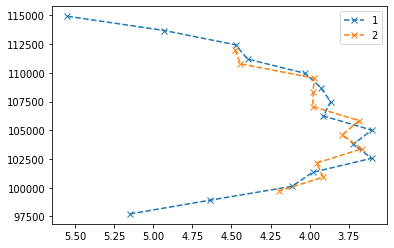

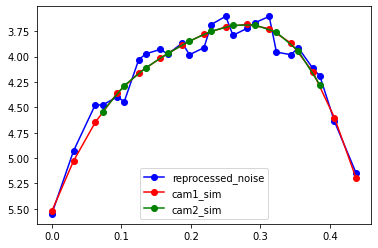

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v57.50_m5.91e-04g_rho0795_z45.6_abl0.014_eh118.3_er0.868_s2.42.json


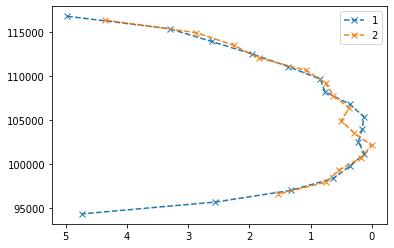

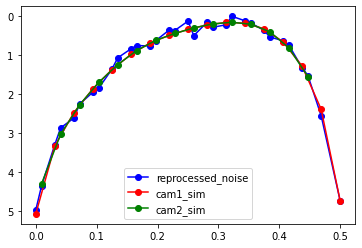

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v59.84_m1.33e-02g_rho0209_z39.8_abl0.014_eh117.3_er0.636_s1.61.json


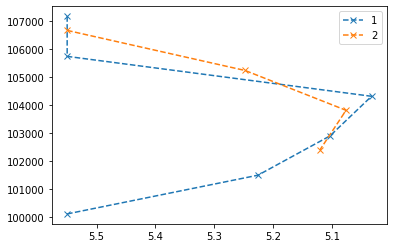

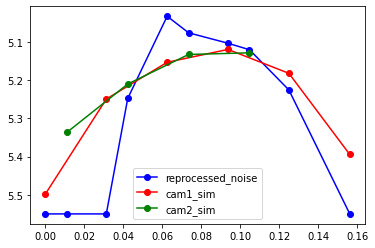

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v60.05_m1.05e-04g_rho0588_z39.3_abl0.009_eh108.3_er0.763_s2.08.json


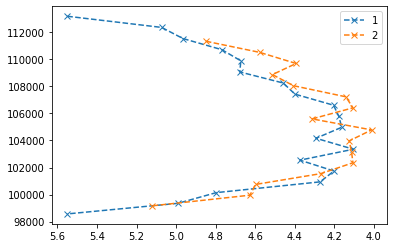

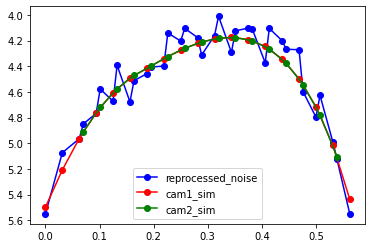

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v61.46_m6.96e-04g_rho0240_z63.2_abl0.015_eh116.1_er0.169_s1.50.json


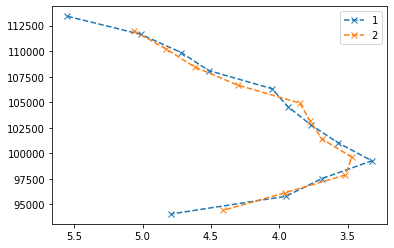

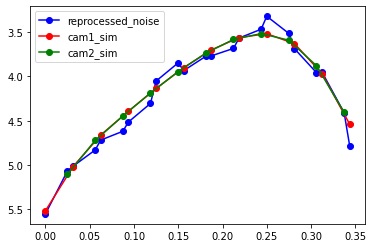

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v62.58_m5.79e-04g_rho0723_z24.4_abl0.011_eh118.6_er0.832_s2.24.json


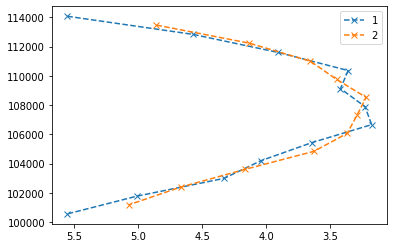

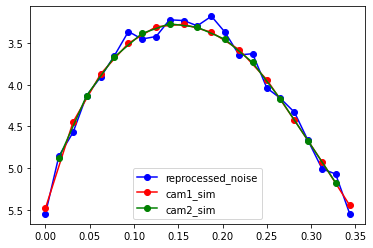

Saved fit parameters to: C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam\erosion_sim_v65.00_m7.01e-04g_rho0709_z51.7_abl0.015_eh115.2_er0.483_s2.46.json


In [4]:
# save the new pickle file in here
save_pickle_path=r"C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\New_2cam"

min_frames_visible=MIN_FRAMES_VISIBLE
check_only=False
param_class=ErosionSimParametersEMCCD_PER_v57_slow
param_class_name="ErosionSimParametersEMCCD_PER_v57_slow"
postprocess_params=None
walk_inputdir=r"C:\Users\maxiv\Documents\UWO\Papers\1)PCA\Reproces_2cam\testFolder\Old_1cam"

# walk all the data and get the pickle files
for root, dirs, files in os.walk(walk_inputdir):
    for file in files:
        if file.endswith(".pickle"):
            # open the pickle file TRUEerosion_sim_v57.50_m5.91e-04g_rho0795_z45.6_abl0.014_eh118.3_er0.868_s2.42.pickle in C:\Users\maxiv\WMPG-repoMAX\Code\PCA\ReProces2cam\Old_1cam
            with open(os.path.join(root, file), "rb") as f:
                sim = pickle.load(f)

            # def extractSimData(sim, min_frames_visible=MIN_FRAMES_VISIBLE, check_only=False, param_class=None, \
            #     param_class_name=None, postprocess_params=None):

            # Create a fresh instance of the system parameters if the same parameters are used as in the simulation
            if param_class is not None:
                params = param_class()

            # Create a fresh class given its name
            elif param_class_name is None:

                params = globals()[sim.params.__class__.__name__]()

            # Override the system parameters using the given class name
            else:
                params = globals()[param_class_name]()

            ### DRAW LIMITING MAGNITUDE AND LENGTH DELAY ###


            # If the drawn values have already been given, use them
            if postprocess_params is not None:
                lim_mag, lim_mag_len, len_delay = postprocess_params

            else:

                # Draw limiting magnitude and length end magnitude
                lim_mag     = np.random.uniform(params.lim_mag_brightest, params.lim_mag_faintest)
                lim_mag_len = np.random.uniform(params.lim_mag_len_end_brightest, params.lim_mag_len_end_faintest)

                # Draw the length delay
                len_delay = np.random.uniform(params.len_delay_min, params.len_delay_max)

                postprocess_params = [lim_mag, lim_mag_len, len_delay]


            lim_mag_faintest  = np.max([lim_mag, lim_mag_len])
            lim_mag_brightest = np.min([lim_mag, lim_mag_len])

            ### ###

            # Fix NaN values in the simulated magnitude
            sim.simulation_results.abs_magnitude[np.isnan(sim.simulation_results.abs_magnitude)] \
                = np.nanmax(sim.simulation_results.abs_magnitude)


            # Get indices that are above the faintest limiting magnitude
            indices_visible = sim.simulation_results.abs_magnitude <= lim_mag_faintest

            # # If no points were visible, skip this solution
            # if not np.any(indices_visible):
            #     return None

            ### CHECK METEOR VISIBILITY WITH THE BRIGTHER (DETECTION) LIMITING MAGNITUDE ###
            ###     (in the CAMO widefield camera)                                       ###

            # Get indices of magnitudes above the brighter limiting magnitude
            indices_visible_brighter = sim.simulation_results.abs_magnitude >= lim_mag_brightest

            # # If no points were visible, skip this solution
            # if not np.any(indices_visible_brighter):
            #     return None

            # Compute the minimum time the meteor needs to be visible
            min_time_visible = min_frames_visible/params.fps + len_delay

            time_lim_mag_bright  = sim.simulation_results.time_arr[indices_visible_brighter]
            time_lim_mag_bright -= time_lim_mag_bright[0]

            # # Check if the minimum time is satisfied
            # if np.max(time_lim_mag_bright) < min_time_visible:
            #     return None

            ### ###

            # Get the first index after the magnitude reaches visibility in the wide field
            index_first_visibility = np.argwhere(indices_visible_brighter)[0][0]

            # Set all visibility indices before the first one visible in the wide field to False
            indices_visible[:index_first_visibility] = False


            # Select time, magnitude, height, and length above the visibility limit
            time_visible = sim.simulation_results.time_arr[indices_visible]
            mag_visible  = sim.simulation_results.abs_magnitude[indices_visible]
            ht_visible   = sim.simulation_results.brightest_height_arr[indices_visible]
            len_visible  = sim.simulation_results.brightest_length_arr[indices_visible]


            # Resample the time to the system FPS
            mag_interpol = scipy.interpolate.CubicSpline(time_visible, mag_visible)
            ht_interpol  = scipy.interpolate.CubicSpline(time_visible, ht_visible)
            len_interpol = scipy.interpolate.CubicSpline(time_visible, len_visible)

            # Sample the time according to the FPS from one camera
            time_sampled_cam1 = np.arange(np.min(time_visible), np.max(time_visible), 1.0/params.fps)

            # Simulate sampling of the data from a second camera, with a random phase shift
            time_sampled_cam2 = time_sampled_cam1 + np.random.uniform(-1.0/params.fps, 1.0/params.fps)

            # The second camera will only capture 50 - 100% of the data, simulate this
            cam2_portion = np.random.uniform(0.5, 1.0)
            cam2_start = np.random.uniform(0, 1.0 - cam2_portion)
            cam2_start_index = int(cam2_start*len(time_sampled_cam2))
            cam2_end_index = int((cam2_start + cam2_portion)*len(time_sampled_cam2))

            # Cut the cam2 time to the portion of the data it will capture
            time_sampled_cam2 = time_sampled_cam2[cam2_start_index:cam2_end_index]

            # Cut the time array to the length of the visible data
            time_sampled_cam2 = time_sampled_cam2[(time_sampled_cam2 >= np.min(time_visible)) 
                                                    & (time_sampled_cam2 <= np.max(time_visible))]

            # Combine the two camera time arrays
            time_sampled = np.sort(np.concatenate([time_sampled_cam1, time_sampled_cam2]))

            # Create new mag, height and length arrays at FPS frequency
            mag_sampled = mag_interpol(time_sampled)
            ht_sampled = ht_interpol(time_sampled)
            len_sampled = len_interpol(time_sampled)


            # Normalize time to zero
            time_sampled -= time_sampled[0]


            ### SIMULATE CAMO tracking delay for length measurements ###

            # Zero out all length measurements before the length delay (to simulate the delay of CAMO
            #   tracking)
            len_sampled[time_sampled < len_delay] = 0

            ###

            # Set all magnitudes below the brightest limiting magnitude to the faintest magnitude
            mag_sampled[mag_sampled > lim_mag] = params.lim_mag_len_end_faintest


            # Normalize the first length to zero
            first_length_index = np.argwhere(time_sampled >= len_delay)[0][0]
            len_sampled[first_length_index:] -= len_sampled[first_length_index]


            # ### Plot simulated data
            # fig, (ax1, ax2, ax3) = plt.subplots(nrows=3)

            # ax1.plot(time_sampled, mag_sampled)
            # ax1.invert_yaxis()
            # ax1.set_ylabel("Magnitude")

            # ax2.plot(time_sampled, len_sampled/1000)
            # ax2.set_ylabel("Length (km)")

            # ax3.plot(time_sampled, ht_sampled/1000)
            # ax3.set_xlabel("Time (s)")
            # ax3.set_ylabel("Height (km)")

            # plt.subplots_adjust(hspace=0)

            # plt.show()

            # ### ###



            # # Check that there are any length measurements
            # if not np.any(len_sampled > 0):
            #     return None


            # # If the simulation should only be checked that it's good, return the postprocess parameters used to 
            # #   generate the data
            # if check_only:
            #     return postprocess_params


            ### ADD NOISE ###

            # Add noise to magnitude data
            mag_sampled[mag_sampled <= lim_mag] += np.random.normal(loc=0.0, scale=params.mag_noise, \
                size=len(mag_sampled[mag_sampled <= lim_mag]))

            # Add noise to length data
            len_sampled[first_length_index:] += np.random.normal(loc=0.0, scale=params.len_noise, \
                size=len(len_sampled[first_length_index:]))

            ### ###

            # Construct input data vector with normalized values
            input_data_normed = sim.getNormalizedInputs()


            # Normalize simulated data
            ht_normed, len_normed, mag_normed = sim.normalizeSimulations(params, ht_sampled, len_sampled, mag_sampled)


            # Generate vector with simulated data
            simulated_data_normed = np.vstack([padOrTruncate(ht_normed, params.data_length), \
                padOrTruncate(len_normed, params.data_length), \
                padOrTruncate(mag_normed, params.data_length)])
            

                # # Return input data and results
                # return params, time_sampled, ht_sampled, len_sampled, mag_sampled, input_data_normed, simulated_data_normed

            # Convert synthetic data to lists
            sim.time_sampled = time_sampled.tolist()
            sim.ht_sampled = ht_sampled.tolist()
            sim.len_sampled = len_sampled.tolist()
            sim.mag_sampled = mag_sampled.tolist()

            # put in a pandas dataframe time_sampled ht_sampled len_sampled mag_sampled
            df = pd.DataFrame(list(zip(time_sampled, ht_sampled, len_sampled, mag_sampled)), columns =['time_sampled', 'ht_sampled', 'len_sampled', 'mag_sampled'])

            # find in the index of camera 1 and camera 2 base if time_sampled % 0.03125 < 0.000000001 ==cam1 and the rest cam2
            time_cam1= [i for i in time_sampled if i % 0.03125 < 0.000000001]
            time_cam2= [i for i in time_sampled if i % 0.03125 > 0.000000001]
            # find the index of the camera 1 and camera 2 in the dataframe
            index_cam1_df= df[df['time_sampled'].isin(time_cam1)].index
            index_cam2_df= df[df['time_sampled'].isin(time_cam2)].index


            # plot the magnitude and time and the 2 cameras against the altitude index_cam1_df and index_cam2_df
            plt.plot(df['mag_sampled'][index_cam1_df],df['ht_sampled'][index_cam1_df], marker='x', linestyle='--', label='1')
            plt.plot(df['mag_sampled'][index_cam2_df],df['ht_sampled'][index_cam2_df], marker='x', linestyle='--', label='2')
            plt.gca().invert_xaxis()
            plt.legend()
            plt.show()


            # plot the magnitude and time and the 2 cameras time_sampled_cam1 and time_sampled_cam2
            # subtract from time_sampled_cam1 the time_sampled_cam1[0] and the same for time_sampled_cam2
            time_sampled_cam1_0=time_sampled_cam1-time_sampled_cam1[0]
            time_sampled_cam2_0=time_sampled_cam2-time_sampled_cam1[0]
            plt.plot(time_sampled, mag_sampled, marker='o', linestyle='-', color='b', label='reprocessed_noise')
            plt.plot(time_sampled_cam1_0, mag_interpol(time_sampled_cam1), marker='o', linestyle='-', color='r', label='cam1_sim')
            plt.plot(time_sampled_cam2_0, mag_interpol(time_sampled_cam2), marker='o', linestyle='-', color='g', label='cam2_sim')
            plt.gca().invert_yaxis()
            plt.legend()
            plt.show()

            # save the new pickle file in here
            saveJSON(sim, save_pickle_path)
